In [1]:
#ENV["JULIA_CUDA_MEMORY_LIMIT"] = 10^10

In [2]:
using CUDA; 
using Knet
using MLDatasets
using LinearAlgebra
using PyPlot
using JLD
include("resnet34_new.jl")

ResNet34 (generic function with 1 method)

In [3]:
#X = load("preprocessed_train.jld")

In [4]:
#X = X["data"]

In [5]:
function loss_contrastive(model, x)
    
    LARGE_NUM = 1e9
    temperature = 1.0
    weights = 1.0
    
    z = model(x)
    
    z = transpose(z)
    
    _atype = KnetArray{Float32}
    
    norm_z = sqrt.(sum(abs2,z,dims=2))
    
    zx = z ./ norm_z

    
    bs = size(zx)[1]÷2
    z1 = zx[1:bs,:]
    z2 = zx[bs+1:bs*2,:]
    
    n = size(z1)[1]
    
    labels = convert(_atype, Array{Float64}(I, n, n*2))
    mask = convert(_atype, Array{Float64}(I, n, n)*LARGE_NUM)

    logits_aa = z1*transpose(z1) - mask
    logits_bb = z2*transpose(z2) - mask
    logits_ab = z1*transpose(z2)
    logits_ba = z2*transpose(z1)
    
    loss_a = sum(-labels.*logsoftmax([logits_ab logits_aa], dims=2))/n
    loss_b = sum(-labels.*logsoftmax([logits_ba logits_bb], dims=2))/n
    
    loss = loss_a + loss_b
    
    loss
end

loss_contrastive (generic function with 1 method)

In [6]:
function loss_contrastive(model, x)
    
    LARGE_NUM = 1e9
    temperature = 0.5
    weights = 1.0
    
    z = model(x)
    
    z = transpose(z)
    
    _atype = KnetArray{Float32}
    
    norm_z = sqrt.(sum(abs2,z,dims=2))
    
    zx = z ./ norm_z

    
    bs = size(zx)[1]÷2
    z1 = zx[1:bs,:]
    z2 = zx[bs+1:bs*2,:]
    
    n = size(z1)[1]
    
    labels = convert(_atype, Array{Float64}(I, n, n*2))
    mask = convert(_atype, Array{Float64}(I, n, n)*LARGE_NUM)

    logits_aa = z1*transpose(z1)/temperature - mask 
    logits_bb = z2*transpose(z2)/temperature - mask 
    logits_ab = z1*transpose(z2)/temperature
    logits_ba = z2*transpose(z1)/temperature
    
    loss_a = sum(-labels.*logsoftmax([logits_ab logits_aa], dims=2))/n
    loss_b = sum(-labels.*logsoftmax([logits_ba logits_bb], dims=2))/n
    
    loss = loss_a + loss_b
    
    loss
end

loss_contrastive (generic function with 1 method)

In [7]:
Array{Float64}(I, 3, 3*2)

3×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0

In [27]:
function load_cifar_dataset(bsize)
    xtrn,ytrn = CIFAR10.traindata(Float32);
    #xtrn = permutedims(xtrn, (2, 1, 3, 4));
    xtst,ytst = CIFAR10.testdata(Float32);
    #xtst = permutedims(xtst, (2, 1, 3, 4));
    println("Loaded CIFAR Data:")
    println.(summary.((xtrn,ytrn,xtst,ytst)))
    dtrn = minibatch(xtrn, ytrn, bsize, xsize=(size(xtrn)[1], size(xtrn)[2], 3, bsize))
    dtst = minibatch(xtst, ytst, bsize, xsize=(size(xtrn)[1], size(xtrn)[2], 3, bsize))
    println("Generated minibatches")
    println.(summary.((dtrn, ytrn)))
    dtrn, dtst
end

load_cifar_dataset (generic function with 1 method)

In [12]:
function load_preprocess_cifar_dataset(bsize)
    xtrn,ytrn = CIFAR10.traindata(Float32);
    X = load("preprocessed_train.jld")
    X = X["data"]
    #println("Loaded CIFAR Data:")
    #println.(summary.((X,ytrn)))
    dtrn = minibatch(X, ytrn, bsize, xsize=(size(xtrn)[1], size(xtrn)[2], 6, bsize),shuffle=true )
    #println("Generated minibatches")
    #println.(summary.((dtrn, ytrn)))
    dtrn
end

load_preprocess_cifar_dataset (generic function with 1 method)

In [13]:
bsize = 512
#dtrn = load_preprocess_cifar_dataset(bsize);
#model = ResNet34(pretrained=false, in_channels=3, out_channels=10)

In [14]:
model = SequentialModule(ResNet34(pretrained=false, in_channels=3, out_channels=512),DenseLayer(512,128))

SequentialModule((SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), K32(128)[1.0⋯])]),

In [15]:
#model = ResNet34(pretrained=false, in_channels=3, out_channels=10)

In [16]:
for p in params(model)
    p.opt = Adam(lr=0.001)
end

In [17]:
epochs = 100
train_loss = zeros(epochs);

In [18]:
for i in 1:epochs
    println("Epoch ", i)
    train_loss[i] = 0.0
    batch_count = 0
    dtrn = load_preprocess_cifar_dataset(bsize);
    for (x, y) in dtrn
        x2 = cat(x[:,:,1:3,:], x[:,:,4:6,:], dims=4)
        loss = @diff loss_contrastive(model, x2)
        train_loss[i] += value(loss)
        batch_count += 1
        for p in params(model)
            g = grad(loss, p)
            update!(value(p), g, p.opt)
        end
    end
    train_loss[i] /= batch_count
    println("Train epoch loss: ", train_loss[i])
    #GC.gc()
end

Epoch 1
Train epoch loss: 12.782479590976362
Epoch 2
Train epoch loss: 12.433364278262424
Epoch 3
Train epoch loss: 12.244722287679457
Epoch 4
Train epoch loss: 12.10271937576766
Epoch 5
Train epoch loss: 11.997863445085349
Epoch 6
Train epoch loss: 11.918950955892347
Epoch 7
Train epoch loss: 11.855942893274051
Epoch 8
Train epoch loss: 11.790615838827547
Epoch 9
Train epoch loss: 11.739861557164144
Epoch 10
Train epoch loss: 11.667324951014567
Epoch 11
Train epoch loss: 11.606750871717315
Epoch 12
Train epoch loss: 11.553510597071696
Epoch 13
Train epoch loss: 11.49084907217124
Epoch 14
Train epoch loss: 11.423863951692876
Epoch 15
Train epoch loss: 11.358541616459483
Epoch 16
Train epoch loss: 11.296825379440465
Epoch 17
Train epoch loss: 11.243261111151313
Epoch 18
Train epoch loss: 11.170319006615077
Epoch 19
Train epoch loss: 11.107947408538504
Epoch 20
Train epoch loss: 11.055206377481676
Epoch 21
Train epoch loss: 11.009346617865809
Epoch 22
Train epoch loss: 10.95302341893776


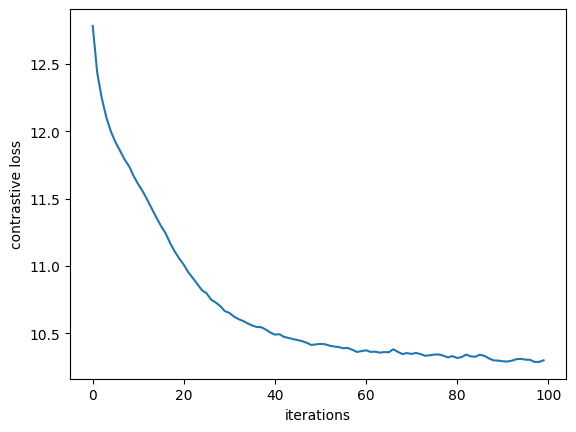

In [19]:
plt.plot(train_loss);
plt.ylabel("contrastive loss");
plt.xlabel("iterations");

In [11]:
GC.gc()

In [12]:
CUDA.memory_status()

Effective GPU memory usage: 87.35% (13.888 GiB/15.899 GiB)
CUDA allocator usage: 13.077 GiB
binned usage: 13.077 GiB (431.286 MiB allocated, 12.656 GiB cached)


In [13]:
image = []

Any[]

In [14]:
for (x, y) in dtrn
    image = x
    break
    return image
end

In [15]:
image1 = convert(Array, image[:,:,:,5]);

In [16]:
#image1 = convert(Array, image[:,:,:,5]);
#image1 = permutedims(image1, (2, 1, 3));

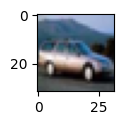

PyObject <matplotlib.image.AxesImage object at 0x7f10d83c0c10>

In [17]:
plt.figure(figsize=(1,1))
plt.imshow(image1)

In [21]:
x2 = 0
t = 0
for (x, y) in dtrn
    x2 = cat(x[:,:,1:3,:], x[:,:,4:6,:], dims=4)
    print(x)
    t = model(x2)
    return t, x2
    break
end

LoadError: UndefVarError: dtrn2 not defined

In [25]:
t

128×1024 KnetArray{Float32,2}:
  -2.85216    -2.95785    12.2142    …   27.5789     -2.60477    3.43572
   7.42897     6.91762    14.8215       -15.3952     19.2737     8.01797
   0.316655  -13.3806      0.412821      -0.576625  -19.1573    -3.74969
  11.0052      9.62619     1.20577      -12.4841     22.7617     2.16661
  39.7565     15.3725      0.243594     -17.846      17.5322    -0.139197
  30.1567      9.81891   -13.1902    …   -2.62621    21.2321    -5.36322
   2.96002   -10.4261      9.11182        3.84038    -5.51499    4.35404
 -29.2636     14.4203    -14.3174         3.78205    13.3685    -5.81779
  -3.13056     9.99212    -0.197821       3.52942     7.74225   -1.48241
  12.8278      5.91052   -10.1779        -2.93488    -7.84852   -3.91903
  -6.59326    -7.3961     11.7607    …   11.8251    -10.4103     4.32857
 -41.2285     21.3048     -2.71645       -2.87748    12.0551    -1.71179
  10.6193     -3.08018    12.1394        -0.341751    1.67346    5.91068
   ⋮               

In [26]:
t = t'

1024×128 KnetArray{Float32,2}:
  -2.85216    7.42897     0.316655   11.0052    …   57.0523     -26.1808
  -2.95785    6.91762   -13.3806      9.62619      -13.6213       6.27022
  12.2142    14.8215      0.412821    1.20577       -8.32384      6.4426
   6.67348   -3.20266     3.02765    18.7517         1.86174     -8.78794
   6.87834   -0.711923  -12.7944    -10.8475        -3.25338    -12.0064
 -10.4553     0.608125    4.60305     4.53174   …   18.8467       6.35275
  18.6832    32.9666    -10.3301      2.75558      -14.4122       6.00793
 -11.4923     0.371234    0.702922   -1.72474        0.92667     -3.43903
  50.63     -74.6891     -6.53508   -41.0363       -52.0295      22.0012
 -14.2705     8.13766    -3.80199    -2.29445       12.7348     -12.4242
   3.95495    3.67079    20.323     -14.2266    …  -10.231      -10.1975
 -14.42       2.31062     2.24199    -3.12092        1.24343     -4.16985
 -14.6092     1.5375      2.73908    -3.15209        1.48838     -4.21472
   ⋮         

In [29]:
t[513,:]

128-element KnetArray{Float32,1}:
  -6.2932043
   7.2528634
   2.1773136
   9.319871
  37.794758
  33.318207
  -0.16029884
 -33.379566
  -5.5468154
  10.535665
  -7.0201597
 -37.680534
  11.865298
   ⋮
 -32.270332
 -35.770363
  29.853855
  -0.25638938
  23.68201
  -8.147982
 -17.756739
   7.351357
   4.5611596
   4.337354
  58.249493
 -20.644213

In [36]:
t[1,:]

128-element KnetArray{Float32,1}:
  -2.8521569
   7.428967
   0.31665513
  11.005243
  39.75653
  30.156702
   2.9600208
 -29.26362
  -3.1305568
  12.827771
  -6.593259
 -41.22847
  10.619343
   ⋮
 -33.05504
 -39.842995
  32.4139
  -1.622196
  19.748003
  -9.2931185
 -21.695059
   6.7073565
   5.911008
   4.033893
  57.052322
 -26.180803

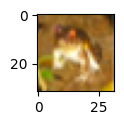

PyObject <matplotlib.image.AxesImage object at 0x7f45ee159a10>

In [34]:
plt.figure(figsize=(1,1))
plt.imshow(Array(x2[:,:,:,1]))

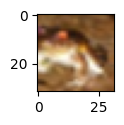

PyObject <matplotlib.image.AxesImage object at 0x7f45eb2e9f90>

In [33]:
plt.figure(figsize=(1,1))
plt.imshow(Array(x2[:,:,:,513]))

In [22]:
model

SequentialModule((SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[0.5400142⋯], K32(1,1,64,1)[0.30828255⋯], zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-3.4562461⋯], K32(1,1,64,1)[16.160778⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-1.9875795⋯], K32(1,1,64,1)[4.810969⋯], zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-2.9737866⋯], K32(1,1,64,1)[19.586277⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLa

In [23]:
for p in params(model)
    print(p.opt)
end

Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(7,7,3,64)[0.0005466068⋯], K32(7,7,3,64)[4.0407736e-5⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[-5.289264e-5⋯], K32(3,3,64,64)[1.1565395e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[-0.0007243066⋯], K32(3,3,64,64)[2.6463686e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[0.0002502142⋯], K32(3,3,64,64)[7.2810064e-7⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[-7.8995174e-5⋯], K32(3,3,64,64)[2.068249e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[-0.00026203867⋯], K32(3,3,64,64)[1.2260718e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,64)[0.00039418644⋯], K32(3,3,64,64)[1.8638874e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,64,128)[0.00011386624⋯], K32(3,3,64,128)[1.6726427e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(3,3,128,128)[0.0006077764⋯], K32(3,3,128,128)[1.2894836e-6⋯])Adam(0.001, 0.9, 0.999, 1.0e-8, 9700, 0.0, K32(1,1,64,1

In [24]:
model_base = model.layers[1]

SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[0.5400142⋯], K32(1,1,64,1)[0.30828255⋯], zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-3.4562461⋯], K32(1,1,64,1)[16.160778⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-1.9875795⋯], K32(1,1,64,1)[4.810969⋯], zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-2.9737866⋯], K32(1,1,64,1)[19.586277⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Fl

In [25]:
model_ftune = SequentialModule(model_base, DenseLayer(512,10))

SequentialModule((SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[0.5400142⋯], K32(1,1,64,1)[0.30828255⋯], zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-3.4562461⋯], K32(1,1,64,1)[16.160778⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-1.9875795⋯], K32(1,1,64,1)[4.810969⋯], zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-2.9737866⋯], K32(1,1,64,1)[19.586277⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLa

In [28]:
dtrn2,dtst2 = load_cifar_dataset(bsize)

Loaded CIFAR Data:
32×32×3×50000 Array{Float32,4}
50000-element Array{Int64,1}
32×32×3×10000 Array{Float32,4}
10000-element Array{Int64,1}
Generated minibatches
97-element Knet.Train20.Data{Tuple{KnetArray{Float32,N} where N,Array{Int64,N} where N}}
50000-element Array{Int64,1}


(97-element Knet.Train20.Data{Tuple{KnetArray{Float32,N} where N,Array{Int64,N} where N}}, 19-element Knet.Train20.Data{Tuple{KnetArray{Float32,N} where N,Array{Int64,N} where N}})

In [29]:
for p2 in params(model_ftune.layers[2])
    p2.opt = Adam(lr=0.001)
end

In [30]:
epochs = 100
train_loss2 = zeros(epochs);
test_loss2 = zeros(epochs);
train_acc2 = zeros(epochs);
test_acc2 = zeros(epochs);

In [31]:
function nll_loss(model, x, y)
    scores = model(x)
    loss = nll(scores, y)
    return loss
end

nll_loss (generic function with 1 method)

In [32]:
for i in 1:epochs
    println("Epoch ", i)
    train_loss2[i] = 0.0
    test_loss2[i] = 0.0
    train_loss2[i] = 0.0
    test_loss2[i] = 0.0
    train_acc2[i] = 0.0
    test_acc2[i] = 0.0
    batch_count = 0
    batch_count2 = 0
    for (x2, y2) in dtrn2
        #x2 = cat(x[:,:,1:3,:], x[:,:,4:6,:], dims=4)
        loss2 = @diff nll_loss(model_ftune, x2, y2)
        train_loss2[i] += value(loss2)
        batch_count += 1
        for p2 in params(model_ftune.layers[2])
            g2 = grad(loss2, p2)
            update!(value(p2), g2, p2.opt)
        end
    end
    for (x2_test, y2_test) in dtst2
        scores2 =  model_ftune(x2_test)
        test_acc2[i] += accuracy(scores2, y2_test)
        batch_count2 += 1
    end
    train_loss2[i] /= batch_count
    test_acc2[i] /= batch_count2
    println("Train epoch loss: ", train_loss2[i])
    println("Test epoch accuracy: ", test_acc2[i])
    #GC.gc()
end

Epoch 1
Train epoch loss: 2.1895205396966837
Test epoch accuracy: 0.2704593112815554
Epoch 2
Train epoch loss: 1.929072828636956
Test epoch accuracy: 0.28827469828728414
Epoch 3
Train epoch loss: 1.8915589470224283
Test epoch accuracy: 0.30322123862618044
Epoch 4
Train epoch loss: 1.8653824009846167
Test epoch accuracy: 0.31157302928188824
Epoch 5
Train epoch loss: 1.8457155645508128
Test epoch accuracy: 0.3178573746746855
Epoch 6
Train epoch loss: 1.8302078443704193
Test epoch accuracy: 0.323415681540321
Epoch 7
Train epoch loss: 1.8175520208693041
Test epoch accuracy: 0.3284043176195701
Epoch 8
Train epoch loss: 1.8069520058091153
Test epoch accuracy: 0.3332993875507771
Epoch 9
Train epoch loss: 1.7978912149507975
Test epoch accuracy: 0.3364950531650177
Epoch 10
Train epoch loss: 1.7900181726082085
Test epoch accuracy: 0.3393445644089462
Epoch 11
Train epoch loss: 1.7830847047038914
Test epoch accuracy: 0.34298490055472236
Epoch 12
Train epoch loss: 1.7769102263696415
Test epoch accu

In [101]:
for (x2_test, y2_test) in dtst2
    scores2 =  model_ftune(x2_test)
    print(y2_test,"\n")
    print(map( y -> y[1], argmax(scores2, dims=1)))
    break
end

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [97]:
? argmax()

search: argmax



```
argmax(itr) -> Integer
```

Return the index of the maximum element in a collection. If there are multiple maximal elements, then the first one will be returned.

The collection must not be empty.

# Examples

```jldoctest
julia> argmax([8,0.1,-9,pi])
1

julia> argmax([1,7,7,6])
2

julia> argmax([1,7,7,NaN])
4
```

---

```
argmax(A; dims) -> indices
```

For an array input, return the indices of the maximum elements over the given dimensions. `NaN` is treated as greater than all other values.

# Examples

```jldoctest
julia> A = [1.0 2; 3 4]
2×2 Array{Float64,2}:
 1.0  2.0
 3.0  4.0

julia> argmax(A, dims=1)
1×2 Array{CartesianIndex{2},2}:
 CartesianIndex(2, 1)  CartesianIndex(2, 2)

julia> argmax(A, dims=2)
2×1 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 2)
 CartesianIndex(2, 2)
```


In [ ]:
accuracy()

In [102]:
model_ftune

SequentialModule((SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(7,7,3,64)), nothing, 3, 2, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-2.2766654⋯], K32(1,1,64,1)[1.3879902⋯], zeros, ones), K32(128)[1.0⋯]), var"#9#12"(), PoolLayer(3, 2, 1, 0), SequentialModule(Any[BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-11.530143⋯], K32(1,1,64,1)[50.851994⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-0.86312014⋯], K32(1,1,64,1)[5.838348⋯], zeros, ones), K32(128)[1.0⋯])]), identity), BasicBlock(SequentialModule(Any[ConvLayer(P(KnetArray{Float32,4}(3,3,64,64)), nothing, 1, 1, identity), BNormLayer2d(Knet.Ops20.BNMoments(0.1f0, K32(1,1,64,1)[-9.07706⋯], K32(1,1,64,1)[31.679686⋯], zeros, ones), K32(128)[1.0⋯]), var"#6#7"(), ConvLay

In [108]:
model_ftune.layers[2].w

P(KnetArray{Float32,2}(10,512))